In [1]:
import xarray as xr
import numpy as np
import functions
import matplotlib.pyplot as plt

In [2]:
datadir = '/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/data/other_cloud_vars/'

## Regrid vertical variables to pressure levels

### Hybrid sigma coordinates at interfaces

In [3]:
savedir = datadir+'regridded_interface_last30yrs/'
exp = 'piClim'
tslice = slice('2040-01-01', '2069-12-31')
var_list = ['TH']
regrid_vars = ['hyai', 'hybi', 'PS', 'P0']

files = []
for var in var_list+regrid_vars:
    files.append(datadir+var+'_'+exp+'.nc')
ds_i = xr.open_mfdataset(files)

ds_slice = ds_i.sel(time=tslice)

var_list = ['TH']
# Regrid timesliced data
for var in var_list:
    var_da = functions.regrid_to_pressure_interfaces(ds_slice,var)
    ds_slice[var] = var_da[var]

ds_slice = ds_slice.drop_vars(['hyai', 'hybi', 'P0', 'PS'])
ds_slice.to_netcdf(savedir+exp+'_new.nc')

In regrid_to_pressure atf.function. Regridding TH to pressure levels


### Hybrid sigma coordinates at midpoints

In [21]:
savedir = datadir+'regridded_midpoint_last30yrs/'
exp = 'abrupt-4xCO2'
tslice = slice('2040-01-01', '2069-12-31')
#var_list = ['CLOUD', 'RELHUM', 'Q', 'T']
var_list = ['U','V','OMEGA']
regrid_vars = ['hyam', 'hybm', 'PS', 'P0']

files = []
for var in var_list+regrid_vars:
    files.append(datadir+var+'_'+exp+'.nc')
ds_i = xr.open_mfdataset(files)

ds_slice = ds_i.sel(time=tslice)

# Regrid timesliced data
for var in var_list:
    var_da = functions.regrid_to_pressure(ds_slice,var)
    ds_slice[var] = var_da[var]

ds_slice = ds_slice.drop_vars(['hyam', 'hybm', 'P0', 'PS','lev'])
print(ds_slice)
ds_slice.to_netcdf(savedir+exp+'_dyn.nc')

In regrid_to_pressure atf.function. Regridding U to pressure levels


In regrid_to_pressure atf.function. Regridding V to pressure levels
In regrid_to_pressure atf.function. Regridding OMEGA to pressure levels
<xarray.Dataset> Size: 4GB
Dimensions:  (lat: 96, lon: 144, time: 360, plev: 32)
Coordinates:
  * lat      (lat) float64 768B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon      (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) object 3kB 2040-01-15 00:00:00 ... 2069-12-15 00:00:00
  * plev     (plev) float64 256B 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
Data variables:
    U        (time, plev, lat, lon) float64 1GB dask.array<chunksize=(360, 32, 96, 144), meta=np.ndarray>
    V        (time, plev, lat, lon) float64 1GB dask.array<chunksize=(360, 32, 96, 144), meta=np.ndarray>
    OMEGA    (time, plev, lat, lon) float64 1GB dask.array<chunksize=(360, 32, 96, 144), meta=np.ndarray>


## Open variables for analysis

In [3]:
filedir = datadir+'regridded_midpoint_last30yrs/'
exp_list = ['piClim', 'abrupt-2xCO2', 'abrupt-4xCO2']
Arctic_lim = 60

ds_list = []
for exp in exp_list:
    files = filedir+exp+'.nc'
    #files = filedir+exp+'_dyn.nc'
    ds_i = xr.open_dataset(files)
    ds_list.append(ds_i.sel(lat=slice(Arctic_lim, 90)))

ds = xr.concat(ds_list, dim='co2_conc')
ds = ds.assign_coords({'co2_conc':exp_list})

In [11]:
filedir = datadir+'regridded_interface_last30yrs/'
exp_list = ['piClim', 'abrupt-2xCO2', 'abrupt-4xCO2']
Arctic_lim = 60

ds_list = []
for exp in exp_list:
    files = filedir+exp+'_new.nc'
    ds_i = xr.open_dataset(files)
    ds_list.append(ds_i.sel(lat=slice(Arctic_lim, 90)))

ds_if = xr.concat(ds_list, dim='co2_conc')
ds_if = ds_if.assign_coords({'co2_conc':exp_list})

## Create regional masks

In [4]:
landmask = xr.open_dataarray(datadir+'LANDFRAC_piClim.nc')
landmask = landmask.isel(time=0)
oceanmask = 1-landmask

In [5]:
maskdir = '/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/data/'
tslice = slice('2040-01-01', '2069-12-31')

ds_masks_piClim = xr.open_dataset(maskdir+'N1850_f19_tn14_noresm2_3_slf_output_20250529.camextra.concatfiles.nc')
ds_masks_4xCO2 = xr.open_dataset(maskdir+'N1850_f19_tn14_noresm2_3_slf_output_4xCO2_20250529.camextra.concatfiles.nc')

# Fix time stamp
ds_masks_piClim = functions.fix_cam_time(ds_masks_piClim)
ds_masks_4xCO2 = functions.fix_cam_time(ds_masks_4xCO2)

icemask_piClim = ds_masks_piClim['ICEFRAC'].sel(time=tslice).groupby('time.season').mean('time')
icemask_4xCO2 = ds_masks_4xCO2['ICEFRAC'].sel(time=tslice).groupby('time.season').mean('time')

oceanmask_season = xr.broadcast(oceanmask, icemask_piClim.season)[0]
openocean_piClim = oceanmask_season - icemask_piClim
openocean_4xCO2 = oceanmask_season - icemask_4xCO2

#openocean_strict = oceanmask - icemask_strict

<xarray.DataArray ()> Size: 8B
array(178)
Coordinates:
    time     object 8B 1920-01-15 00:00:00
    season   <U3 12B 'JJA'
<xarray.DataArray 'LANDFRAC' ()> Size: 8B
array(554)
Coordinates:
    time     object 8B 1920-01-15 00:00:00


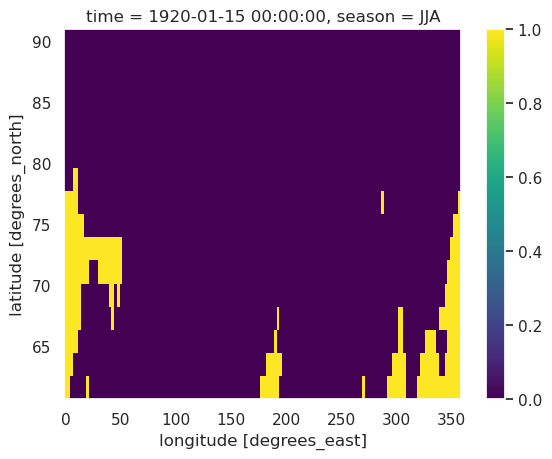

In [17]:
(openocean_piClim.sel(season='JJA', lat=slice(60,90)) > 0.8).plot()
print((openocean_piClim.sel(season='JJA', lat=slice(60,90)) > 0.8).sum())
print((landmask.sel(lat=slice(60,90), lon=slice(0,300)) > 0.8).sum())
openocean_2 = openocean_piClim.sel(season='JJA', lat=slice(60,90)) > 0.8
landmask_2 = landmask.sel(lat=slice(60,90)) > 0.8

## Create seasonal means

In [14]:
ds_seasons = ds.groupby('time.season').mean('time')

In [12]:
ds_if_seasons = ds_if.groupby('time.season').mean('time')

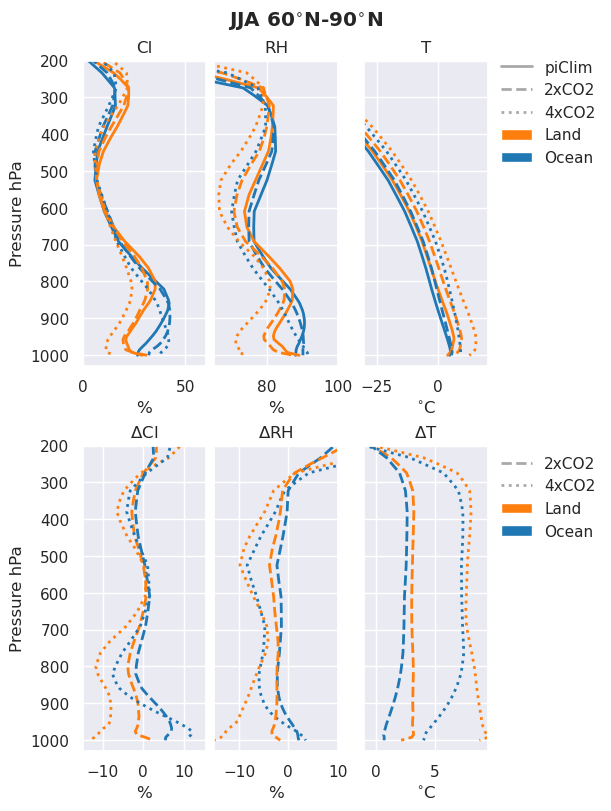

In [18]:
import seaborn as sns
sns.set_theme()
ONLY_OPEN_OCEAN = True
EXCLUDE_GREENLAND = True
season = 'JJA'
Arctic_limit = 60
linestyles = ['-','--',':']
vars = ['CLOUD','RELHUM','T']
xlims = [[0,60], [65,100], [-30,20]]
xlims_delta = [[-15,15.5], [-15,10], [-1,9.5]]
names = ['Cl', 'RH', 'T']
units = ['%', '%', '$^{\circ}$C']

fig, axs = plt.subplots(2, 3, figsize=(6,8), sharey=True, constrained_layout=True)
fig.suptitle(season+' '+str(Arctic_limit)+'$^{\circ}$N-90$^{\circ}$N', fontweight='bold')

for i, var, xlim, xlim_delta, name, unit in zip(range(3),vars, xlims, xlims_delta, names, units):
    if EXCLUDE_GREENLAND:
        Arctic_lnd_piClim = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), lon=slice(0,290), season=season, co2_conc='piClim'), landmask_2.sel(lat=slice(Arctic_limit, 90), lon=slice(0,300)))
        Arctic_lnd_2xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), lon=slice(0,290), season=season, co2_conc='abrupt-2xCO2'), landmask_2.sel(lat=slice(Arctic_limit, 90), lon=slice(0,300)))
        Arctic_lnd_4xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), lon=slice(0,290), season=season, co2_conc='abrupt-4xCO2'), landmask_2.sel(lat=slice(Arctic_limit, 90), lon=slice(0,300)))
    else:
        Arctic_lnd_piClim = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc='piClim'), landmask.sel(lat=slice(Arctic_limit, 90)))
        Arctic_lnd_2xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc='abrupt-2xCO2'), landmask.sel(lat=slice(Arctic_limit, 90)))
        Arctic_lnd_4xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc='abrupt-4xCO2'), landmask.sel(lat=slice(Arctic_limit, 90)))
    
    if ONLY_OPEN_OCEAN:
        # piClim summer > 0.8
        Arctic_ocn_piClim = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc='piClim'), openocean_2.sel(lat=slice(Arctic_limit, 90)))
        Arctic_ocn_2xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc='abrupt-2xCO2'), openocean_2.sel(lat=slice(Arctic_limit, 90)))
        Arctic_ocn_4xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc='abrupt-4xCO2'), openocean_2.sel(lat=slice(Arctic_limit, 90)))
    else:
        Arctic_ocn_piClim = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc='piClim'), oceanmask.sel(lat=slice(Arctic_limit, 90)))
        Arctic_ocn_2xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc='abrupt-2xCO2'), oceanmask.sel(lat=slice(Arctic_limit, 90)))
        Arctic_ocn_4xCO2 = functions.computeWeightedMeanMasked(ds_seasons[var].sel(lat=slice(Arctic_limit, 90), season=season, co2_conc='abrupt-4xCO2'), oceanmask.sel(lat=slice(Arctic_limit, 90)))

    d_lnd_2xCO2 = Arctic_lnd_2xCO2-Arctic_lnd_piClim
    d_ocn_2xCO2 = Arctic_ocn_2xCO2-Arctic_ocn_piClim
    d_lnd_4xCO2 = Arctic_lnd_4xCO2-Arctic_lnd_piClim
    d_ocn_4xCO2 = Arctic_ocn_4xCO2-Arctic_ocn_piClim

    if var=='T':
        axs[0][i].plot((Arctic_ocn_piClim)-273.15, ds_seasons.plev, color='tab:blue', linestyle = linestyles[0],lw=2,label='piClim ocean')
        axs[0][i].plot((Arctic_lnd_piClim)-273.15, ds_seasons.plev, color='tab:orange', linestyle = linestyles[0], lw=2,label='piClim land')
        axs[0][i].plot((Arctic_ocn_2xCO2)-273.15, ds_seasons.plev, color='tab:blue', linestyle = linestyles[1],lw=2,label='2xCO2 ocean')
        axs[0][i].plot((Arctic_lnd_2xCO2)-273.15, ds_seasons.plev, color='tab:orange', linestyle = linestyles[1], lw=2,label='2xCO2 land')
        axs[0][i].plot((Arctic_ocn_4xCO2)-273.15, ds_seasons.plev, color='tab:blue', linestyle = linestyles[2],lw=2,label='4xCO2 ocean')
        axs[0][i].plot((Arctic_lnd_4xCO2)-273.15, ds_seasons.plev, color='tab:orange', linestyle = linestyles[2],lw=2, label='4xCO2 land')
        
        axs[1][i].plot(d_lnd_2xCO2, ds_seasons.plev, color='tab:orange', linestyle = linestyles[1],lw=2,label='2xCO2 land')
        axs[1][i].plot(d_ocn_2xCO2, ds_seasons.plev, color='tab:blue', linestyle = linestyles[1], lw=2,label='2xCO2 land-ocean')
        axs[1][i].plot(d_lnd_4xCO2, ds_seasons.plev, color='tab:orange', linestyle = linestyles[2],lw=2,label='4xCO2 land')
        axs[1][i].plot(d_ocn_4xCO2, ds_seasons.plev, color='tab:blue', linestyle = linestyles[2], lw=2,label='4xCO2 land-ocean')


    elif var=='CLOUD':
        axs[0][i].plot((Arctic_ocn_piClim)*100, ds_seasons.plev, color='tab:blue', linestyle = linestyles[0],lw=2,label='piClim ocean')
        axs[0][i].plot((Arctic_lnd_piClim)*100, ds_seasons.plev, color='tab:orange', linestyle = linestyles[0], lw=2,label='piClim land')
        axs[0][i].plot((Arctic_ocn_2xCO2)*100, ds_seasons.plev, color='tab:blue', linestyle = linestyles[1],lw=2,label='2xCO2 ocean')
        axs[0][i].plot((Arctic_lnd_2xCO2)*100, ds_seasons.plev, color='tab:orange', linestyle = linestyles[1], lw=2,label='2xCO2 land')
        axs[0][i].plot((Arctic_ocn_4xCO2)*100, ds_seasons.plev, color='tab:blue', linestyle = linestyles[2],lw=2,label='4xCO2 ocean')
        axs[0][i].plot((Arctic_lnd_4xCO2)*100, ds_seasons.plev, color='tab:orange', linestyle = linestyles[2], lw=2,label='4xCO2 land')
        
        axs[1][i].plot((d_lnd_2xCO2)*100, ds_seasons.plev, color='tab:orange', linestyle = linestyles[1],lw=2,label='2xCO2 land')
        axs[1][i].plot((d_ocn_2xCO2)*100, ds_seasons.plev, color='tab:blue', linestyle = linestyles[1], lw=2,label='2xCO2 land-ocean')
        axs[1][i].plot((d_lnd_4xCO2)*100, ds_seasons.plev, color='tab:orange', linestyle = linestyles[2],lw=2,label='4xCO2 land')
        axs[1][i].plot((d_ocn_4xCO2)*100, ds_seasons.plev, color='tab:blue', linestyle = linestyles[2], lw=2,label='4xCO2 land-ocean')


    else:
        axs[0][i].plot((Arctic_ocn_piClim), ds_seasons.plev, color='tab:blue', linestyle = linestyles[0],lw=2,label='piClim ocean')
        axs[0][i].plot((Arctic_lnd_piClim), ds_seasons.plev, color='tab:orange', linestyle = linestyles[0], lw=2,label='piClim land')
        axs[0][i].plot((Arctic_ocn_2xCO2), ds_seasons.plev, color='tab:blue', linestyle = linestyles[1],lw=2,label='2xCO2 ocean')
        axs[0][i].plot((Arctic_lnd_2xCO2), ds_seasons.plev, color='tab:orange', linestyle = linestyles[1], lw=2, label='2xCO2 land')
        axs[0][i].plot((Arctic_ocn_4xCO2), ds_seasons.plev, color='tab:blue', linestyle = linestyles[2],lw=2,label='4xCO2 ocean')
        axs[0][i].plot((Arctic_lnd_4xCO2), ds_seasons.plev, color='tab:orange', linestyle = linestyles[2],lw=2, label='4xCO2 land')
    
        axs[1][i].plot(d_ocn_2xCO2, ds_seasons.plev, color='tab:blue', linestyle = linestyles[1],lw=2, label='2xCO2 land-ocean')
        axs[1][i].plot(d_ocn_4xCO2, ds_seasons.plev, color='tab:blue', linestyle = linestyles[2], lw=2,label='4xCO2 land-ocean')
        axs[1][i].plot(d_lnd_2xCO2, ds_seasons.plev, color='tab:orange', linestyle = linestyles[1],lw=2,label='2xCO2 land')
        axs[1][i].plot(d_lnd_4xCO2, ds_seasons.plev, color='tab:orange', linestyle = linestyles[2],lw=2,label='4xCO2 land')


    axs[0][i].set_ylim([1030,200])
    axs[0][i].set_xlabel(unit)
    axs[0][i].set_title(name)
    axs[0][i].set_xlim(xlim)
    #axs[0][i].grid()

    axs[1][i].set_ylim([1030,200])
    axs[1][i].set_xlabel(unit)
    axs[1][i].set_title('$\Delta$'+name)
    axs[1][i].set_xlim(xlim_delta)
    #axs[1][i].grid()

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_elements_1 = [Line2D([0], [0], color='darkgrey', lw=2, linestyle=linestyles[0], label='piClim'),
                   Line2D([0], [0], color='darkgrey', lw=2, linestyle=linestyles[1], label='2xCO2'),
                   Line2D([0], [0], color='darkgrey', lw=2, linestyle=linestyles[2], label='4xCO2'),
                   Patch(facecolor='tab:orange', label='Land'),
                   Patch(facecolor='tab:blue', label='Ocean')]

legend_elements_2 = [Line2D([0], [0], color='darkgrey', lw=2, linestyle=linestyles[1], label='2xCO2'),
                   Line2D([0], [0], color='darkgrey', lw=2, linestyle=linestyles[2], label='4xCO2'),
                   Patch(facecolor='tab:orange', label='Land'),
                   Patch(facecolor='tab:blue', label='Ocean')]

axs[0][0].set_ylabel('Pressure hPa')
axs[1][0].set_ylabel('Pressure hPa')
axs[0][2].legend(handles=legend_elements_1, loc='center left', bbox_to_anchor=(1, 0.83),frameon=False)
axs[1][2].legend(handles=legend_elements_2, loc='center left', bbox_to_anchor=(1, 0.83),frameon=False)

fig.savefig('/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/arctic-cloud-feedbacks/article_figs/Fig2.png')
fig.savefig('/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/arctic-cloud-feedbacks/article_figs/Fig2.pdf')
plt.show()